In [ ]:
import pandas as pd
import numpy as np

import time, datetime
from tqdm import tqdm
tqdm.pandas()

import requests
import urllib.request
from bs4 import BeautifulSoup

import re
import os, sys, glob

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

from sklearn import preprocessing

from konlpy.tag import Komoran
from collections import Counter
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


---

## Data 전처리

- Process
    1. 데이터프레임 정리
    2. 일별 의견 수 정리
    3. 주식 의견데이터 명사 구분 및 BOW로 Feature Vector화

---
### 1. 데이터프레임 정리

#### 데이터프레임 불러오기

In [ ]:
# 크롤링한 데이터 파일 불러오기.

comment_path = "./dataset/comment/"
df_comment = pd.read_csv(comment_path+"dcinside_nasdaq.csv", index_col=0, encoding="utf-8", parse_dates=True)
df_comment.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,Title,View,Like,Reply
0,2022-11-01,fomc 제롬파월 연설 동시통역 방송 보기,946,2,6
1,2020-12-27,★ 필 독 ★,223871,713,643
2,2022-05-27,신고/건의/신문고,10276,5,492
3,2021-07-29,미국주식갤러리는 매수매도의 책임을 지지 않습니다,13781,25,18
4,2022-06-21,주식 정보사이트 정리,12440,22,18


#### 데이터프레임 확인

In [ ]:
df_comment

,Date,Title,View,Like,Reply
0,2022-11-01,fomc 제롬파월 연설 동시통역 방송 보기,946,2,6
1,2020-12-27,★ 필 독 ★,223871,713,643
2,2022-05-27,신고/건의/신문고,10276,5,492
3,2021-07-29,미국주식갤러리는 매수매도의 책임을 지지 않습니다,13781,25,18
4,2022-06-21,주식 정보사이트 정리,12440,22,18
...,...,...,...,...,...
3744085,2020-03-14,미붕이들 이쯤되면,47,0,1
3744086,2020-03-14,무슨 한국이 대만이랑 비슷해 무식한넘...,167,2,5
3744087,2020-03-14,지금 시점에 갤럭시Z플립이 아이폰 보다 이쁘지 않을까?,129,3,3
3744088,2020-03-14,내 첩도 애플 좋아하더라,167,1,4


#### 전처리

In [ ]:
# 필요없는 데이터 rows 제거: <공지사항> 제거

df_comment.drop(index=df_comment.index[:8], inplace=True)

In [ ]:
### 전처리 항목:
# 1. 중복 제거
# 2. 정렬
# 3. 컬럼 통일

df_comment.drop_duplicates("Title", ignore_index=True, inplace=True)
df_comment.sort_values("Date", ascending=False, ignore_index=True, inplace=True)
df_comment.reset_index(drop=True, inplace=True)

In [ ]:
# 일단 의견 데이터만 이용.
df_comment.drop(columns=["Like", "Reply", "View"], inplace=True)

df_comment

,Date,Title
0,2022-11-02,엑손모빌같은거 대체 왜 오르는지 모르겠네
1,2022-11-02,인버스 하지 말라는 이유가 뭐냐?
2,2022-11-02,반지하 오래 살면 안됨
3,2022-11-02,민지야 모니터 두개로 해라.
4,2022-11-02,스큐 추매 언제할까?
...,...,...
3630431,2020-03-13,코스피는 3000이못와 ㅋㅋㅋ
3630432,2020-03-12,사람마다 가져가는 투자전략이 다른거 뿐임
3630433,2020-03-12,이익잉여금 가치측정법을 소개한다.
3630434,2019-08-01,미장 5개월차 맘속규칙


In [ ]:
# 중복데이터 제거
print("원본 데이터 shape: ", df_comment.shape)
df_comment.drop_duplicates("Title", ignore_index=True, inplace=True)
print("중복 데이터 제거 후 shape: ", df_comment.shape)

원본 데이터 shape:  (3630436, 2)
중복 데이터 제거 후 shape:  (3630436, 2)


In [ ]:
# null 확인
df_comment.isnull().sum()

Date     0
Title    1
dtype: int64

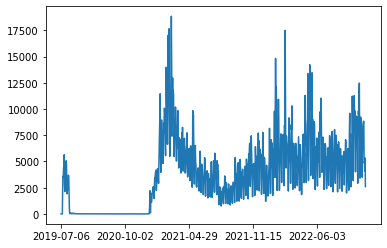

In [ ]:
# 일자 별, 데이터 분포 확인
df_comment.sort_values(by='Date').Date.value_counts(sort=False).plot()

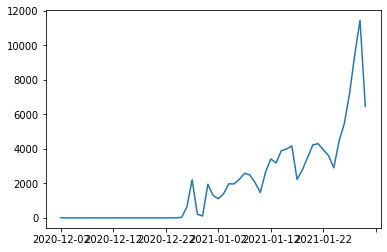

In [ ]:
# "2020-12-01" ~ "2021-01-31" 사이의 데이터 분포 확인.
df_comment.sort_values(by='Date').Date[(df_comment.Date > "2020-12-01") & (df_comment.Date < "2021-01-31")].value_counts(sort=False).plot()

In [ ]:
# 2020-12-31 이전 데이터에 일정부분 손실이 있었음. 따라서 2021-01-01 이후의 데이터만 적용하도록 결정함.

In [ ]:
dropidx = df_comment[(df_comment["Date"] > "2022-10-31") | (df_comment.Date < '2021-01-01')].index

df_comment.drop(index=dropidx, inplace=True)
df_comment

,Date,Title
7930,2022-10-31,메타 멋있네.
7931,2022-10-31,한국은 세율 1%씩 더올려서
7932,2022-10-31,To make the end of battle
7933,2022-10-31,아까 콜드 안산녀석들 ㅋㅋ
7934,2022-10-31,안뒤지고 시간 끌면 나가린데 이거
...,...,...
3551062,2021-01-01,상상중계 하는줄 알았네ㅋㅋㅋㅋ
3551063,2021-01-01,아 시발 나도 나이키 팔고 tpgy 몰빵해?
3551064,2021-01-01,[정보글]새해맞이 선물로 2021년 1분기 스팩주 추천몇개 알려드림
3551065,2021-01-01,해피뉴이어다 개색기덜아.


In [ ]:
df_comment.reset_index(drop=True, inplace=True)

In [ ]:
# Date 컬럼의 데이터 타입 변경 후, 인덱스화
df_comment["Date"] = df_comment.loc[:, "Date"].apply(lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d"))
df_comment.to_csv("./dataset_only_dc/cleaned_data.csv", encoding="utf-8")

#### 데이터 불러오기

In [ ]:
# df_all 불러오기

df_comment = pd.read_csv("./dataset_only_dc/cleaned_data.csv", index_col=0, encoding="utf-8", parse_dates=['Date'])
df_comment.head()

,Date,Title
0,2022-10-31,메타 멋있네.
1,2022-10-31,한국은 세율 1%씩 더올려서
2,2022-10-31,To make the end of battle
3,2022-10-31,아까 콜드 안산녀석들 ㅋㅋ
4,2022-10-31,안뒤지고 시간 끌면 나가린데 이거


In [ ]:
alltext = df_comment.set_index("Date")
alltext

,Title
Date,
2022-10-31,메타 멋있네.
2022-10-31,한국은 세율 1%씩 더올려서
2022-10-31,To make the end of battle
2022-10-31,아까 콜드 안산녀석들 ㅋㅋ
2022-10-31,안뒤지고 시간 끌면 나가린데 이거
...,...
2021-01-01,상상중계 하는줄 알았네ㅋㅋㅋㅋ
2021-01-01,아 시발 나도 나이키 팔고 tpgy 몰빵해?
2021-01-01,[정보글]새해맞이 선물로 2021년 1분기 스팩주 추천몇개 알려드림


In [ ]:
alltext["Title"] = alltext.Title.apply(lambda x: str(x) + ' ')

#### 1) 각 comment마다 명사 추출 후 그룹화.

In [ ]:
from konlpy.tag import Komoran
komoran = Komoran()

nouns_komoran = alltext.copy()
# 특수문자 제거 후, string 타입의 데이터에 대해 명사만 추출
special = re.compile(r'[^ A-Za-z0-9가-힣+]')
nouns_komoran["Title"] = alltext.Title.progress_apply(lambda x: komoran.nouns(special.sub("",x).strip() if type(x) == str else ""))


In [ ]:
nouns_komoran.to_csv("./dataset_only_dc/nouns_komoran.csv", encoding="utf-8-sig")

In [ ]:
nouns_komoran

,Title
Date,
2022-10-31,[메타]
2022-10-31,"[한국, 세율]"
2022-10-31,[]
2022-10-31,"[콜드, 안산, 녀석]"
2022-10-31,[시간]
...,...
2021-01-01,"[상상, 중계, 줄]"
2021-01-01,"[시발, 나이키, 몰, 빵]"
2021-01-01,"[정보, 글, 새해맞이, 선물, 년, 분기, 추천, 개]"


In [ ]:
# 각 일자별로 키워드 모음 - 방법2) groupby
time_index = pd.date_range("2022-10-31", "2021-01-01", freq='-1D')
grouped_keywords_komoran = pd.DataFrame(index=time_index, columns=["nouns"])

for idx in tqdm(time_index):
    grouped_keywords_komoran.at[idx, "nouns"] = nouns_komoran.loc[idx].groupby(level=0).sum().values[0][0]
grouped_keywords_komoran.to_csv("./dataset_only_dc/grouped_keywords_komoran.csv", encoding="utf-8")

100%|██████████| 669/669 [03:56<00:00,  2.83it/s]


In [ ]:
grouped_keywords_komoran

,nouns
2022-10-31,"[메타, 한국, 세율, 콜드, 안산, 녀석, 시간, 오늘, 구라, 세기, 정유, 숏..."
2022-10-30,"[인간, 인식, 것, 따, 이건, 진짜, 거, 이태원, 사태, 일침, 경찰관, 소방..."
2022-10-29,"[이태원, 인, 오, 거, 세상, 가치, 죽음, 사람, 일, 이든, 한녀, 건, 일..."
2022-10-28,"[애플, 만큼, 이랑, 뭐, 회사, 나스닥, 호재, 애플, 실적, 어거지, 개, 생..."
2022-10-27,"[잠깐, 만요, 애플, 안, 수면, 매매, 드, 가자, 쿠팡, 나스닥, 시발, 양전..."
...,...
2021-01-05,"[나, 반반, 이야기, 위, 불, 블랙, 존, 레모네이드, 입, 개, 티어, 양전,..."
2021-01-04,"[인, 모드, 개, 잡주, 년, 선, 달, 예상, 주식, 빗, 코, 퀀텀, 스케이프..."
2021-01-03,"[여유, 있다, 년대, 코, 인질, 프로, 원, 개, 주식, 비트, 자살자, 속출,..."
2021-01-02,"[코, 인, 상당, 부분, 사토시, 거, 관상, 정체, 꿀, 팁, 영어, 까막눈, ..."


#### 2) 일자 별 그룹화 후, tokenizer 이용하여 단어분류

In [ ]:
grouped_keywords = pd.read_csv("./dataset_only_dc/grouped_keywords.csv", index_col=0, encoding="utf-8", parse_dates=True)
grouped_keywords.head()

In [ ]:
# 각 일자별로 키워드 모음 - 방법2) groupby
time_index = pd.date_range("2022-10-31", "2021-01-01", freq='-1D')
grouped_keywords = pd.DataFrame(index=time_index, columns=["title"])

for idx in tqdm(time_index):
    grouped_keywords.at[idx, "Title"] = alltext.loc[idx].groupby(level=0).sum().values[0][0]
grouped_keywords.to_csv("./dataset_only_dc/grouped_keywords.csv", encoding="utf-8")

100%|██████████| 669/669 [01:45<00:00,  6.37it/s]


In [ ]:
alltext.loc["2022-10-31", "Title"].groupby(level=0).sum()

Date
2022-10-31    메타 멋있네.한국은 세율 1%씩 더올려서To make the end of battl...
Name: Title, dtype: object

In [ ]:
grouped_keywords

,title
2022-10-31,메타 멋있네. 한국은 세율 1%씩 더올려서 To make the end of bat...
2022-10-30,아니 내가 인간에 대한 인식이 남다른건가? 숏츙이들 진짜 ㅈ대따 이건 진짠거 같음 ...
2022-10-29,이태원 인싸들 뭐 오케 된거임? 세상에서 가장 가치없는 죽음 저거 밟았을 사람도 걸...
2022-10-28,애플 갈만큼 갔는데 AMZN이랑 SQQQ는 뭐하는 회사인가요? 나스닥 호재 뭐야??...
2022-10-27,잠깐 잠깐만요 잠깐 나 애플 팔고싶은데 살려주면 안되냐 수면매매 드가자~ 쿠팡 미...
...,...
2021-01-05,spy나voo는 항상 qqq에 쳐발리는데 왜 항상 반반이야기가나옴? 위불 pc 블랙...
2021-01-04,인모드 개잡주년 음탕하게 흐르네 선달 +2펔ㅋㅋㅋㅋㅋ컄ㅋㅋㅋㅋ 내 예상이맞았지 주식...
2021-01-03,아직 여유있다 16~17년도에 코인질하다가 -90프로 쳐맞고 그대로 묻어뒀는데 이더...
2021-01-02,코인의 상당부분을 사토시가 가지고 있는거 아님? 관상 물어본 CEO의 정체는 바로....


In [ ]:
grouped_keywords = pd.read_csv("./dataset_only_dc/grouped_keywords.csv", index_col=0, encoding="utf-8", parse_dates=True)
grouped_keywords.head()

,title
2022-10-31,메타 멋있네. 한국은 세율 1%씩 더올려서 To make the end of bat...
2022-10-30,아니 내가 인간에 대한 인식이 남다른건가? 숏츙이들 진짜 ㅈ대따 이건 진짠거 같음 ...
2022-10-29,이태원 인싸들 뭐 오케 된거임? 세상에서 가장 가치없는 죽음 저거 밟았을 사람도 걸...
2022-10-28,애플 갈만큼 갔는데 AMZN이랑 SQQQ는 뭐하는 회사인가요? 나스닥 호재 뭐야??...
2022-10-27,잠깐 잠깐만요 잠깐 나 애플 팔고싶은데 살려주면 안되냐 수면매매 드가자~ 쿠팡 미...


In [ ]:
tokenizer = RegexpTokenizer('\w+')
tokens = grouped_keywords.title.apply(tokenizer.tokenize)
tokens

2022-10-31    [메타, 멋있네, 한국은, 세율, 1, 씩, 더올려서, To, make, the, ...
2022-10-30    [아니, 내가, 인간에, 대한, 인식이, 남다른건가, 숏츙이들, 진짜, ㅈ대따, 이...
2022-10-29    [이태원, 인싸들, 뭐, 오케, 된거임, 세상에서, 가장, 가치없는, 죽음, 저거,...
2022-10-28    [애플, 갈만큼, 갔는데, AMZN이랑, SQQQ는, 뭐하는, 회사인가요, 나스닥,...
2022-10-27    [잠깐, 잠깐만요, 잠깐, 나, 애플, 팔고싶은데, 살려주면, 안되냐, 수면매매, ...
                                    ...                        
2021-01-05    [spy나voo는, 항상, qqq에, 쳐발리는데, 왜, 항상, 반반이야기가나옴, 위...
2021-01-04    [인모드, 개잡주년, 음탕하게, 흐르네, 선달, 2펔ㅋㅋㅋㅋㅋ컄ㅋㅋㅋㅋ, 내, 예상...
2021-01-03    [아직, 여유있다, 16, 17년도에, 코인질하다가, 90프로, 쳐맞고, 그대로, ...
2021-01-02    [코인의, 상당부분을, 사토시가, 가지고, 있는거, 아님, 관상, 물어본, CEO의...
2021-01-01    [Mrna, 백신이, 통과된게, 이게, 보통일이아님, 테슬람주주분들, 지금, 중국산...
Name: title, Length: 669, dtype: object

In [ ]:
model = Word2Vec(tokens, min_count=10)

In [ ]:
def get_document_vectors(tokens):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in tqdm(tokens):
        doc2vec = None
        count = 0
        for word in line:
            if word in model.wv.key_to_index:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model.wv[word]
                else:
                    doc2vec = doc2vec + model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
document_embedding_list = get_document_vectors(tokens)
len(document_embedding_list)

100%|██████████| 669/669 [00:45<00:00, 14.80it/s]


669

In [ ]:
model.save('model_1.model')

In [ ]:
model = Word2Vec.load("model_1.model")

In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (669, 669)


In [ ]:
df_sim = pd.DataFrame(cosine_similarities, index=grouped_keywords.index, columns=grouped_keywords.index )
df_sim

,2022-10-31,2022-10-30,2022-10-29,2022-10-28,2022-10-27,2022-10-26,2022-10-25,2022-10-24,2022-10-23,2022-10-22,...,2021-01-10,2021-01-09,2021-01-08,2021-01-07,2021-01-06,2021-01-05,2021-01-04,2021-01-03,2021-01-02,2021-01-01
2022-10-31,1.000000,0.864144,0.967877,0.960311,0.965934,0.983827,0.990280,0.986880,0.844176,0.944483,...,0.865228,0.895074,0.918449,0.934422,0.936189,0.948936,0.907825,0.864752,0.832285,0.869586
2022-10-30,0.864144,1.000000,0.916867,0.812741,0.817554,0.832250,0.859538,0.838568,0.980723,0.957302,...,0.928183,0.865183,0.852806,0.878936,0.863455,0.860530,0.837560,0.909599,0.932199,0.906055
2022-10-29,0.967877,0.916867,1.000000,0.961721,0.960952,0.971267,0.981098,0.958009,0.917368,0.985363,...,0.943317,0.951552,0.956890,0.964714,0.967364,0.967501,0.934452,0.933264,0.916453,0.940198
2022-10-28,0.960311,0.812741,0.961721,1.000000,0.996506,0.990801,0.972604,0.960531,0.797772,0.909192,...,0.870458,0.926176,0.951866,0.951292,0.955832,0.957847,0.920702,0.857772,0.826676,0.877710
2022-10-27,0.965934,0.817554,0.960952,0.996506,1.000000,0.992673,0.976936,0.966845,0.799878,0.910621,...,0.874414,0.929148,0.955066,0.955307,0.959060,0.961762,0.928003,0.862683,0.832165,0.882616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05,0.948936,0.860530,0.967501,0.957847,0.961762,0.965452,0.962586,0.947434,0.859078,0.933237,...,0.941410,0.970789,0.985673,0.992279,0.993381,1.000000,0.976830,0.937147,0.912021,0.950515
2021-01-04,0.907825,0.837560,0.934452,0.920702,0.928003,0.924544,0.921229,0.912342,0.838622,0.900466,...,0.949178,0.975470,0.983213,0.978787,0.979031,0.976830,1.000000,0.960001,0.926057,0.956386
2021-01-03,0.864752,0.909599,0.933264,0.857772,0.862683,0.867075,0.881374,0.861866,0.923553,0.932839,...,0.989111,0.967212,0.950213,0.951156,0.947114,0.937147,0.960001,1.000000,0.982708,0.979795
2021-01-02,0.832285,0.932199,0.916453,0.826676,0.832165,0.831036,0.848876,0.822751,0.944884,0.929380,...,0.992931,0.951856,0.926135,0.933060,0.928320,0.912021,0.926057,0.982708,1.000000,0.985499


In [ ]:
import FinanceDataReader as fdr

ixic = fdr.DataReader('IXIC', '2020-04-10')[["Close"]]
ixic

,Close
Date,
2020-04-13,8192.419922
2020-04-14,8515.740234
2020-04-15,8393.179688
2020-04-16,8532.360352
2020-04-17,8650.139648
...,...
2022-12-23,10497.860352
2022-12-27,10353.230469
2022-12-28,10213.290039


In [ ]:
df = pd.merge(grouped_keywords, ixic, how='left', left_index=True, right_index=True).fillna(method='backfill')

df["next_close"] = df.Close.shift(-1)
df["change"] = round((df.Close - df.next_close)/df.Close * 100,2)

df

,title,Close,next_close,change
2022-10-31,메타 멋있네. 한국은 세율 1%씩 더올려서 To make the end of bat...,10988.150391,11102.450195,-1.04
2022-10-30,아니 내가 인간에 대한 인식이 남다른건가? 숏츙이들 진짜 ㅈ대따 이건 진짠거 같음 ...,11102.450195,11102.450195,0.00
2022-10-29,이태원 인싸들 뭐 오케 된거임? 세상에서 가장 가치없는 죽음 저거 밟았을 사람도 걸...,11102.450195,11102.450195,0.00
2022-10-28,애플 갈만큼 갔는데 AMZN이랑 SQQQ는 뭐하는 회사인가요? 나스닥 호재 뭐야??...,11102.450195,10792.669922,2.79
2022-10-27,잠깐 잠깐만요 잠깐 나 애플 팔고싶은데 살려주면 안되냐 수면매매 드가자~ 쿠팡 미...,10792.669922,10970.990234,-1.65
...,...,...,...,...
2021-01-05,spy나voo는 항상 qqq에 쳐발리는데 왜 항상 반반이야기가나옴? 위불 pc 블랙...,12818.959961,12698.450195,0.94
2021-01-04,인모드 개잡주년 음탕하게 흐르네 선달 +2펔ㅋㅋㅋㅋㅋ컄ㅋㅋㅋㅋ 내 예상이맞았지 주식...,12698.450195,NaN,NaN
2021-01-03,아직 여유있다 16~17년도에 코인질하다가 -90프로 쳐맞고 그대로 묻어뒀는데 이더...,NaN,NaN,NaN
2021-01-02,코인의 상당부분을 사토시가 가지고 있는거 아님? 관상 물어본 CEO의 정체는 바로....,NaN,NaN,NaN


In [ ]:
def recommendations(input_date, k):
    print(df[df.index == input_date])
    date = datetime.datetime.strptime(input_date, "%Y-%m-%d")
    results = df_sim[date].sort_values(ascending=False)[1:k+1].index

    temp = pd.DataFrame()
    for result in results:
        temp = pd.concat([temp, df[df.index == result]])
    return temp

recommendations("2022-10-27", 5)

                                                        title         Close  \
2022-10-27  잠깐 잠깐만요  잠깐 나 애플 팔고싶은데 살려주면 안되냐 수면매매 드가자~ 쿠팡 미...  10792.669922   

              next_close  change  
2022-10-27  10970.990234   -1.65  


,title,Close,next_close,change
2022-10-28,애플 갈만큼 갔는데 AMZN이랑 SQQQ는 뭐하는 회사인가요? 나스닥 호재 뭐야??...,11102.450195,10792.669922,2.79
2022-02-08,알리바바 >>>>> 메타 갑자기 좆노잼장이라 존나 어색하네 10년물 채권금리 뭐냐...,14194.450195,14015.669922,1.26
2022-04-28,테슬라 왜 이럼ㅠㅠ? 형들 250불로 단타치는거 팁 좀 주라 그래도 음전은 절대 ...,12871.530273,12488.929688,2.97
2022-07-29,쉐브롬 9% 이게 말이되노 스큐 그래도 용케 버티네 자본주의의 붕괴를 내 눈으로 ...,12390.690430,12162.589844,1.84
2022-10-26,우영우는 방구뿡 에피소드 삭제 시켰어야함 ㅋㅋ 모든 소음봉(small dick)에 ...,10970.990234,11199.120117,-2.08


In [ ]:
from sklearn.manifold import TSNE

vocab = model.wv.key_to_index
X = model.wv[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:1000])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
X.shape

(113547, 100)

In [ ]:
vv =sorted(vocab, key=vocab.get)
df = pd.DataFrame(X_tsne, index=vv[:1000], columns=['x','y'])
df

,x,y
오늘,-13.001787,2.344551
ㅋㅋ,-13.126904,-38.039501
왜,-23.110023,25.165070
지금,-7.269606,-9.814125
테슬라,10.147220,-44.394653
...,...,...
삼,-13.672851,-2.807314
기회,-9.596165,-12.418445
새끼들아,3.512750,-14.178107
컄ㅋㅋㅋ,-3.311378,-21.779068


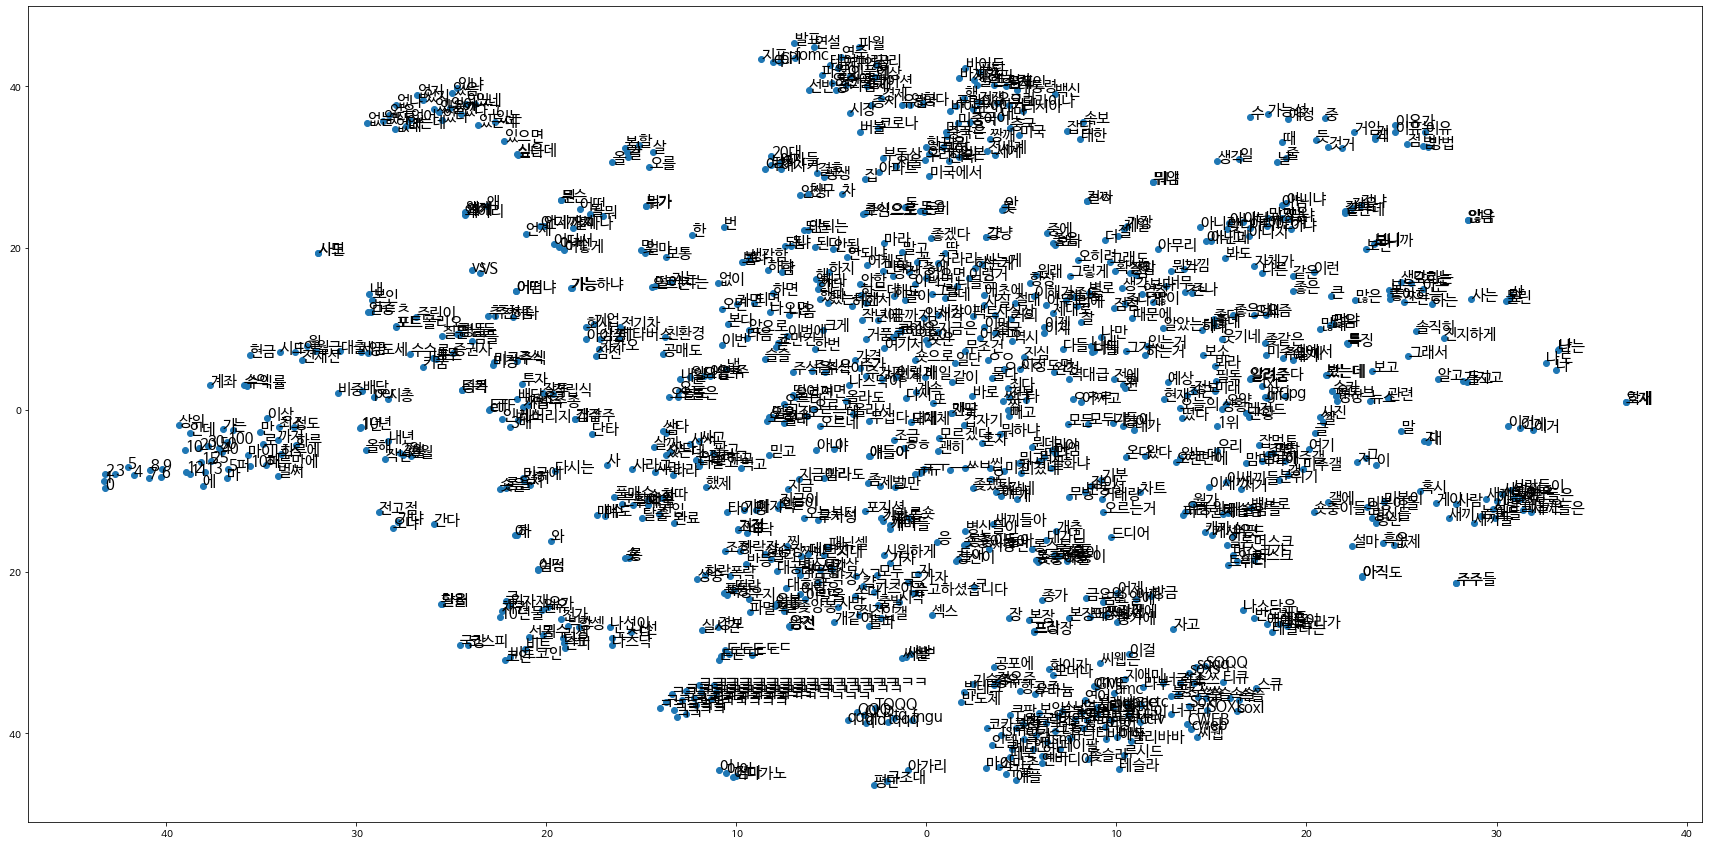

In [ ]:
fig = plt.figure()
fig.set_size_inches(30, 15)
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=10)
plt.show()

#### 번외) 모든 단어 묶음에 대한 워드클라우드

In [ ]:
# 2글자 이상인 경우 + '롱', '숏'만 추출하여 리스트 형식으로 저장
import ast

def over_two_letters(onedata):
    over_two_letters = []
    for v in ast.literal_eval(onedata):
        if len(v) >= 2 or ((v == '롱') | (v == '숏')):
            over_two_letters.append(v)
    return over_two_letters

In [ ]:
# cf) 모든 단어에 대한 워드클라우드
all_words = np.array([])
for idx in tqdm(time_index):
    temp = np.array(over_two_letters(grouped_keywords_komoran.at[idx,"nouns"]))
    all_words = np.append(all_words, temp, axis=0)

all_words = all_words.flatten()
all_words = pd.DataFrame(data=all_words)
all_words.to_csv("./dataset_only_dc/all_words.csv", encoding="utf-8", index=False)
len(all_words)

100%|██████████| 669/669 [14:40<00:00,  1.32s/it]


8193938

In [ ]:
# all words read
all_words = pd.read_csv("./dataset_only_dc/all_words.csv", encoding="utf-8")
all_words

,0
0,메타
1,한국
2,세율
3,콜드
4,안산
...,...
8193933,분기
8193934,추천
8193935,해피
8193936,애플
